In [36]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

#from google.colab import drive
import numpy as np
import pandas as pd

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In this example, we're going to train a [CharRNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) on a body of Shakespearian text. Ultimtely, this is an unsuperived learning task. But similar to our previous explorations in unsupervised DL, we will use an unlabeled dataset and create many samples of labeled data that we can use with our familiar supervised loss functions. The result will be a model that has learned the statistical properties of the input text, and can then be considered a "generative" model of language because we can use it to generate synthetic passages of Shakespeare.  

In [2]:
#drive.mount('/content/gdrive/')

In [3]:
file_path = "shakespeare.txt"

with open(file_path,"r") as f:
  text = f.read()

We've loaded our Shakespeare text, let's take a look at a random snippet.

In [4]:
print(text[31600:32000])

 lies i' the second chamber?
  LADY MACBETH. Donalbain.
  MACBETH. This is a sorry sight.           [Looks on his hands.
  LADY MACBETH. A foolish thought, to say a sorry sight.
  MACBETH. There's one did laugh in 's sleep, and one cried,
      "Murther!"
    That they did wake each other. I stood and heard them,
    But they did say their prayers and address'd them
    Again to sleep.
  LADY MACB


We need to convert our text into numeric arrays, the next several blocks accomplish this.

First, we'll create a mapping between characters and their numeric index. We'll also create the reverse mapping, which is useful.

In [5]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 75


Next, we'll create a training set of sub-sequences. Remember, we're trying to train a model to be able to predict the next chracter if it is given several characters of a subsequence. So we will create training pairs where each X is a fixed-length subsequences and each Y is the corresponding next letter in the text.

In [6]:
maxlen = 40
step = 3
sub_sequences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sub_sequences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sub_sequences))

nb sequences: 38700


In [7]:
k=3564
print("(Sequence):\n" + sub_sequences[k])
print("\n(Target Character): \n" + next_chars[k])

(Sequence):
ne of Cawdor lives. Why do you dress me


(Target Character): 
 


Next we'll create one-hot vectors for our sub-sequences. The tensor we create here will be shaped as (num_sequences x sequence_length x alphabet_size).

In [8]:
X = np.zeros((len(sub_sequences), maxlen, len(chars)), dtype=np.uint8 )
Y = np.zeros((len(sub_sequences), len(chars)), dtype=np.uint8)
for i, seq in enumerate(sub_sequences):
    for t, char in enumerate(seq):
        X[i, t, char_indices[char]] = 1
        Y[i, char_indices[next_chars[i]]] = 1

In [9]:
X[0,0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [10]:
Y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

Our RNN model will be quite simple.

In [11]:
df_tf = tf.data.Dataset.from_tensor_slices((tf.cast(X, tf.uint8), tf.cast(Y, tf.uint8))).cache().batch(1028).repeat().prefetch(10)

In [12]:
char_rnn = Sequential()
char_rnn.add(tfkl.LSTM(128, input_shape=(maxlen, len(chars))))
char_rnn.add(tfkl.Dense(len(chars),activation="softmax"))

In [13]:
char_rnn.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01))

In [14]:
results = char_rnn.fit(df_tf, epochs=20,steps_per_epoch = 1000, batch_size=1024)

Epoch 1/20
1000/1000 [==============================] - 9s 9ms/step - loss: 1.5457
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7721
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5617
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4438
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3683
Epoch 6/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3206
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2834
Epoch 8/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2560
Epoch 9/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2334
Epoch 10/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2184
Epoch 11/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2042
Epoch 12/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1937
E

Once we have a trained model, we can simulate new text by making predictions about the next character and then drawing characters in proportion to the predicted probabilities. And then simple repeat that process over and over, each time drawing the next character.

In [15]:
def draw_char(probs):
    probs = np.asarray(probs).astype('float64')
    if sum(probs) != 1.0:
      probs = probs / np.sum(probs)
    draw = np.random.choice(range(len(probs)) , p=probs)
    return draw

def sample_text(model, sample_length=100):
    start = np.random.randint(0, len(text) - maxlen - 1)
    sequence = text[start: start + maxlen]
  
    x_preds = np.zeros((sample_length, maxlen, len(chars)))
    for i in range(sample_length):
        for t, char in enumerate(sequence[-maxlen:]):
            x_preds[i, t, char_indices[char]] = 1.

        preds = model.predict(np.expand_dims(x_preds[i,:,:], axis=0), verbose=0)[0]
        next_index = draw_char(preds)
        next_char = indices_char[next_index]

        sequence += next_char
    return sequence

In [16]:
sim = sample_text(char_rnn,sample_length=500) 

In [17]:
print(sim)

R. Where is your husband?
  LADY MACDUFF. Every, a many of my way her, marmer,
    For ithout may her? Gooch is pear, IGhe not, Macbeth'd seliech,
    I saw upon thee they were with the think out
    Thou art the knice and tore, my This midest fight.
  ROSS. You bendem, to the can, and trains.
  BANQUO. Here I hapl ob the hanle do the heact,
    And pithen durner cortomen; here seest,
    And so loval butbergul's rut farding.
    Which is to the intus and fill.
    Horest than should wellous here the dutcer'd bees,
    And so lies liv


Notice that we can do pretty well to learn the typical statistical patterns of this text and then simulate new text that appears to be very similar to legitimate Shakespeare. 

But just a caution - we can also do pretty well with a much simpler method (Markov model): http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139

So the lesson is to try something simple before jumping right in to deep learning.

## Exercise

In this example, we're going to use an RNN for sequence classification. The task we'll set up is to generate a training set of randomized strings, and train our model to detect whether a string contains any vowels.

First, we'll create a training dataset of short randomized character sequences and the corresponding label of whether or not they contain at least one vowel.

In [18]:
import string

In [19]:
def contains_vowels(sequence):
  vowels = ["a", "e", "i", "o", "u"]
  return any([vowel in list(sequence) for vowel in vowels])

In [20]:
contains_vowels("gradient")

True

In [39]:
sequences = []
labels = []
for i in range(10000):
 char_list = np.random.choice( list(string.ascii_lowercase), size = 5, replace=True)
 seq = "".join(char_list)
 sequences.append(seq)
 labels.append(int(contains_vowels(seq)))

In [40]:
df = pd.DataFrame({"sequence": sequences, "label":labels})

In [41]:
df.head()

,sequence,label
0,mgvyo,1
1,kfuuc,1
2,pdegy,1
3,zwijn,1
4,ojobv,1


Next, set up and train an RNN (of any type) to solve this task. What preprocessing will you need to do first on the raw data in order to prepare it for the network?

In [42]:
vocab = list(string.ascii_lowercase)
vocab_size = len(vocab)
df['sequence_indices'] = df['sequence'].apply(lambda string: [vocab.index(s) for s in string])

In [25]:
# Data Preprocessing
# your code here
preprocess = lambda df: (tf.one_hot(df['sequence_indices'], depth = vocab_size), df.cast(df['label'],tf.uint8))

In [43]:
df_tf = (tf.data.Dataset.from_tensor_slices((tf.one_hot(np.array(df['sequence_indices'].to_list()), depth = vocab_size), 
                                            tf.cast(np.array(df['label']), tf.uint8)))
         .cache()
         .batch(1028)
         .repeat()
         .prefetch(10))

In [44]:
df_tf

<PrefetchDataset shapes: ((None, 5, 26), (None,)), types: (tf.float32, tf.uint8)>

In [45]:
# first attempt is LSTM as small as possible, only 1 RNN LSTM node
char_rnn = Sequential()
char_rnn.add(tfkl.LSTM(1, input_shape=(5, vocab_size)))
char_rnn.add(tfkl.Dense(1,activation="sigmoid"))
char_rnn.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01))

In [46]:
char_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1)                 112       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


In [47]:
results = char_rnn.fit(df_tf, epochs=5,steps_per_epoch = 500, batch_size=1024)

Epoch 1/5
500/500 [==============================] - 1s 2ms/step - loss: 0.1373
Epoch 2/5
500/500 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 3/5
500/500 [==============================] - 1s 2ms/step - loss: 1.3726e-05
Epoch 4/5
500/500 [==============================] - 1s 2ms/step - loss: 2.8218e-07
Epoch 5/5
500/500 [==============================] - 1s 2ms/step - loss: 3.8774e-08


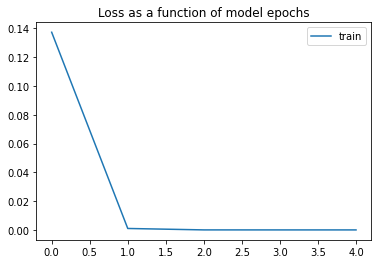

In [48]:
plt.plot(results.history["loss"])
plt.legend(labels=["train"])
plt.title("Loss as a function of model epochs")

plt.show()

In [49]:
# Now try a simple RNN, I needed to use 2 nodes in order for the model to fit well
char_rnn = Sequential()
char_rnn.add(tfkl.SimpleRNN(2, input_shape=(5, vocab_size)))
char_rnn.add(tfkl.Dense(1,activation="sigmoid"))
char_rnn.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01))
results = char_rnn.fit(df_tf, epochs=5,steps_per_epoch = 500, batch_size=1024)

Epoch 1/5
500/500 [==============================] - 2s 3ms/step - loss: 0.1065
Epoch 2/5
500/500 [==============================] - 2s 3ms/step - loss: 1.4188e-05
Epoch 3/5
500/500 [==============================] - 2s 3ms/step - loss: 3.0149e-08
Epoch 4/5
500/500 [==============================] - 2s 3ms/step - loss: 1.5152e-08
Epoch 5/5
500/500 [==============================] - 2s 3ms/step - loss: 1.2024e-08


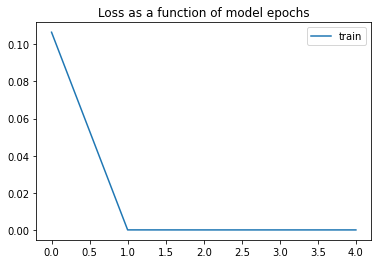

In [50]:
plt.plot(results.history["loss"])
plt.legend(labels=["train"])
plt.title("Loss as a function of model epochs")

plt.show()

In [51]:
# Finally we test to see if a deep neural network can do the job.... it can't
char_rnn = Sequential()
char_rnn.add(tfkl.InputLayer((5, vocab_size)))
char_rnn.add(tfkl.Dense(10,activation="relu"))
char_rnn.add(tfkl.Dense(100,activation="relu"))
char_rnn.add(tfkl.Dense(100,activation="relu"))
char_rnn.add(tfkl.Dense(50,activation="relu"))
char_rnn.add(tfkl.Dense(1,activation="sigmoid"))
char_rnn.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01))
results = char_rnn.fit(df_tf, epochs=5,steps_per_epoch = 1000, batch_size=1024)

Epoch 1/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5534
Epoch 2/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5522
Epoch 3/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5522
Epoch 4/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5522
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5522


In [172]:
char_rnn.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 5, 10)             270       
_________________________________________________________________
dense_90 (Dense)             (None, 5, 100)            1100      
_________________________________________________________________
dense_91 (Dense)             (None, 5, 100)            10100     
_________________________________________________________________
dense_92 (Dense)             (None, 5, 50)             5050      
_________________________________________________________________
dense_93 (Dense)             (None, 5, 1)              51        
Total params: 16,571
Trainable params: 16,571
Non-trainable params: 0
_________________________________________________________________
